In [3]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers, initializers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import PIL 
import re
from PIL import Image
import os

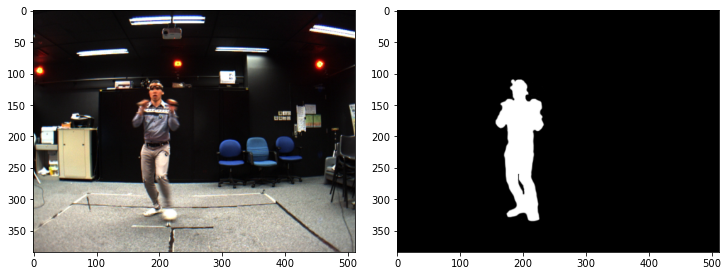

In [5]:
'''
Author: Kenneth Zhang
'''

base_dir = "C:/Users/kzhan/Desktop/segmentation_full_body_mads_dataset_1192_img"
images_path = os.path.join(base_dir + "/images/")
masks_path = os.path.join(base_dir + "/masks/")

sample_original = os.path.join(images_path + "HipHop_HipHop1_C0_00180.png")
sample_semantic = os.path.join(masks_path + "HipHop_HipHop1_C0_00180.png")

fig, axs = plt.subplots(1, 2, figsize = (10, 5), constrained_layout = True)
axs[0].imshow(Image.open(sample_original))
axs[1].imshow(Image.open(sample_semantic))

In [6]:
print(f"No. of Images: {len(os.listdir(images_path))}")
print(f"No. of Image Masks: {len(os.listdir(masks_path))}")

No. of Images: 1192
No. of Image Masks: 1192


In [7]:
class preprocessing_generator():
    def __init__(self, data, path_images, path_masks):
        self.data = data
        self.path_images = path_images
        self.path_masks = path_masks
    
    def sort_alpha(self, data):
        converting_metric = lambda text: int(text) if text.isdigit() else text.lower()
        alpha_numeric_key = lambda key: [converting_metric (c) for c in re.split('([0-9]+)', key)]
        return sorted(self.data, key = alpha_numeric_key)
    
    def load_data(self, path_images, path_masks):
        images = os.listdir(self.path_images)
        masks = os.listdir(self.path_masks)
        images_list, masks_list = [], []
        print(len(images))

        images2, masks2 = sort_alphanumeric(images), sort_alphanumeric(masks)

        for i in images2:
            image = Image.open(path_images + i).convert('RGB')
            image1 = np.array(image.resize((256, 256))) / 255.0
            images_list.append(image1)

        for i in masks2:
            mask = Image.open(path_masks + i).convert('RGB')
            mask1 = np.array(mask.resize((256, 256))) / 255.0
            masks_list.append(mask1)
        
        return images_list, masks_list

def sort_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert (c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key = alphanum_key)

def load_images_masks(path_images, path_masks):
    images, masks = os.listdir(images_path), os.listdir(masks_path)
    images_list, masks_list = [], []
    print(len(images))

    images2, masks2 = sort_alphanumeric(images), sort_alphanumeric(masks)

    for i in images2:
        im = Image.open(path_images + i).convert('RGB')
        im1 = np.array(im.resize((128, 128))) / 255.0
        images_list.append(im1)
    
    for i in masks2:
        mask = Image.open(path_masks + i).convert('RGB')
        mask1 = np.array(mask.resize((128, 128))) / 255.0
        masks_list.append(mask1)
    
    return images_list, masks_list

X, y = load_images_masks(images_path, masks_path)
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

1192
(1192, 128, 128, 3) (1192, 128, 128, 3)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(953, 128, 128, 3) (953, 128, 128, 3)
(239, 128, 128, 3) (239, 128, 128, 3)


In [9]:
from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

def UNet_Architecture():
    inputs = Input(shape = (128, 128, 3))

    c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2)) (c1)

    c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2)) (c2)

    c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2)) (c3)

    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1]) #removed ,axis=3
    c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='relu') (c9)
    unet_network = tf.keras.Model(inputs = inputs, outputs = outputs)
    return unet_network

unet_network = UNet_Architecture()
unet_network.compile(optimizer = 'adam', loss = 'binary_crossentropy')
unet_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 8)    0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
print(f"Non-trainable Weights: {unet_network.non_trainable_weights}")
print(f"Trainable Weights: {unet_network.trainable_weights}")

Non-trainable Weights: []
Trainable Weights: [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 8) dtype=float32, numpy=
array([[[[ 0.1998969 , -0.01897584, -0.00044267, -0.13476473,
          -0.10272504,  0.06476578, -0.0861446 ,  0.15900713],
         [-0.03899728, -0.15894249, -0.1095605 ,  0.16248658,
          -0.00611082,  0.18646345, -0.08914617, -0.21795022],
         [ 0.12234408,  0.09702235, -0.03971142, -0.05222745,
          -0.09559131,  0.03858277, -0.12162324, -0.06270972]],

        [[ 0.02078599,  0.23503253, -0.13210869,  0.0724805 ,
          -0.13185576,  0.03252414,  0.2331286 ,  0.06934854],
         [ 0.04540449, -0.12512648,  0.04423505, -0.09675664,
           0.00504357,  0.03791589,  0.02561983,  0.11728725],
         [ 0.1739837 , -0.13840303, -0.03152686, -0.06813732,
          -0.23875646, -0.07969141, -0.24037327,  0.14845842]],

        [[-0.04799499, -0.16934846, -0.00473776,  0.04626989,
          -0.15930313,  0.08735999,  0.07183868,  0.17604911],
   

In [11]:
def FCN_Vgg16_32s(input_shape=None, weight_decay=0., batch_momentum=0.9, batch_shape=None, classes=21):
    if batch_shape:
        img_input = Input(batch_shape=batch_shape)
        image_size = batch_shape[1:3]
    else:
        img_input = Input(shape=input_shape)
        image_size = input_shape[0:2]
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    x = BilinearUpSampling2D(size=(32, 32))(x)

    model = Model(img_input, x)

    weights_path = os.path.expanduser(os.path.join('~', '.keras/models/fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5'))
    model.load_weights(weights_path, by_name=True)
    return model

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)

print("There are ", X_train.shape[0], " samples for the training set.")
print("There are ", X_test.shape[0], " samples for the testing set.")

(953, 128, 128, 3) (953, 128, 128, 3)
There are  953  samples for the training set.
There are  239  samples for the testing set.


In [14]:
unet_network.fit(X_train, y_train, epochs = 100)

Epoch 1/100
 7/30 [======>.......................] - ETA: 12s - loss: 0.2628

KeyboardInterrupt: 